In [0]:
# remove this line to get outputs
%%capture
##########
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install plotly
!apt-get update

!pip install soundfile
!apt-get install libsndfile-dev -y

## Some stuff for google drive integration from google colab

To use: create the folder /Colab_Notebooks/MobyDick in your base google drive directory.

In [0]:
##https://colab.research.google.com/notebook#fileId=1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q&scrollTo=XoDG4oKpoeyS
# remove this line to get outputs
%%capture
##########
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!fusermount -u drive
!rmdir drive
!mkdir -p drive

!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
rmdir: failed to remove 'drive': No such file or directory


In [6]:
import os
print('Files in Drive:')
basePath = 'drive/Colab_Notebooks/MobyDick'
escapedBasePath = str.replace(basePath, ' ', '\ ')
print(os.listdir(basePath))

Files in Drive:
['whale_data.zip', 'whale_trainlabels.npy', 'whale_traindata.npy', 'processed_data.npy', 'processed_data_250ms.npy', 'spectrogram_simplenet.ipynb', 'data_proc.npy', 'HMM_fun.ipynb', 'dwt_format_data.ipynb', 'Guion Whale Data.odt', 'format_data.ipynb']


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [0]:
from google.colab import files

def upload_stuff():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
    with open(fn, 'w') as f:
      f.write(uploaded[fn])
  
  return uploaded

### Function for separating data into overlapping windows and Mel Filter Bank generation

In [0]:
from __future__ import division

def windower(x, M, N):
    # M avance entre vetanas
    # N windowsize

    T   = x.shape[0]
    m   = np.arange(0, T-N+1, M) # comienzos de ventana
    L   = m.shape[0] # N ventanas
    ind = np.expand_dims(np.arange(0, N), axis=1) * np.ones((1,L)) + np.ones((N,1)) * m
    X   = x[ind.astype(int)]
    return X.transpose()
  
def gen_whalefb_mtx(NFFT, nfilt, sample_rate):
    
    low_freq_mel = 40
    
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    return fbank

In [0]:
from google.colab import files

We use 32 filters taken the region of 40-1000 Hz. In this range, the MFB weighs all frequencies almost linearly, with slightly more resolution assigned to the lower frequencies. This is consistent with the energy distribution of whale upcalls. 

(32, 129)


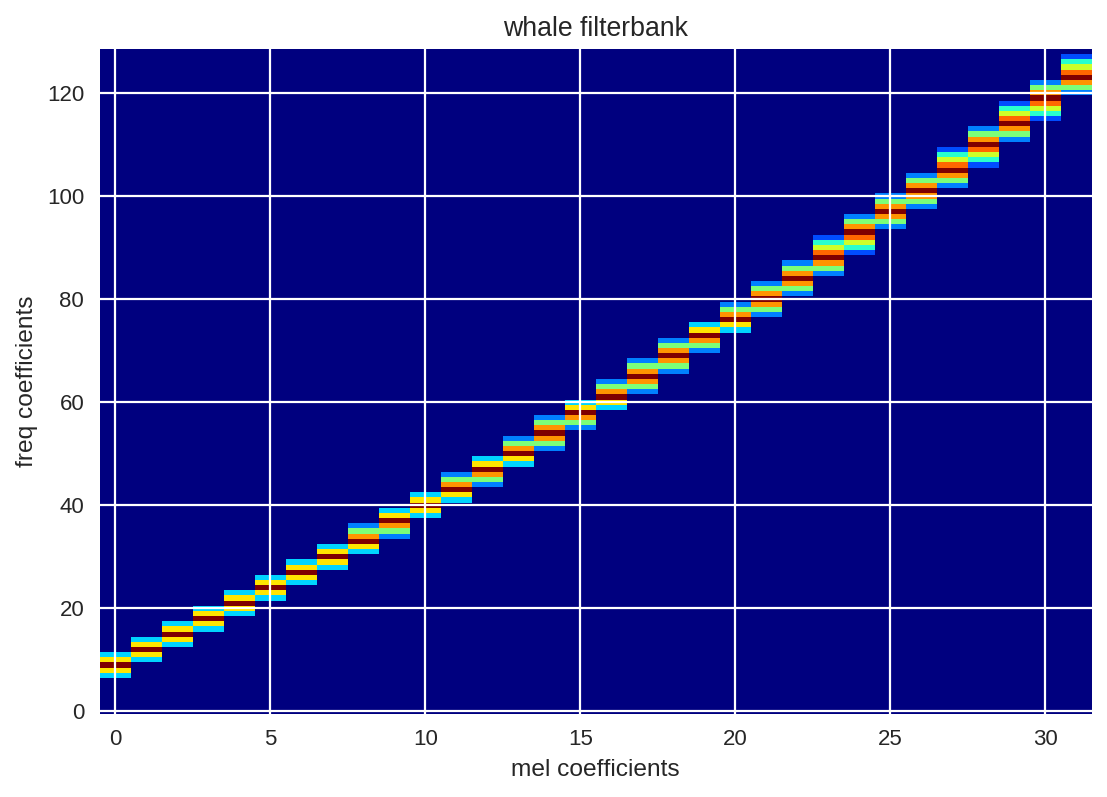

In [11]:
mfb = gen_whalefb_mtx(NFFT=256, nfilt=32, sample_rate=1000)

print(mfb.shape)

plt.figure(dpi=160)
plt.imshow(mfb.T, cmap='jet',  aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('mel coefficients')
plt.ylabel('freq coefficients')
plt.title('whale filterbank')
plt.savefig('filterbank.png')

# files.download('filterbank.png')

### Load data

In [0]:
labels = np.load(basePath + '/' + 'whale_trainlabels.npy')
sounds = np.load(basePath + '/' + 'whale_traindata.npy')

###Separate data into overlapping windows, apply hamming window and compute FFT

('label:', 0)
('x_win:', (160, 250))
('s:', (160, 128))
float32


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Text(0,0.5,u'Freq')

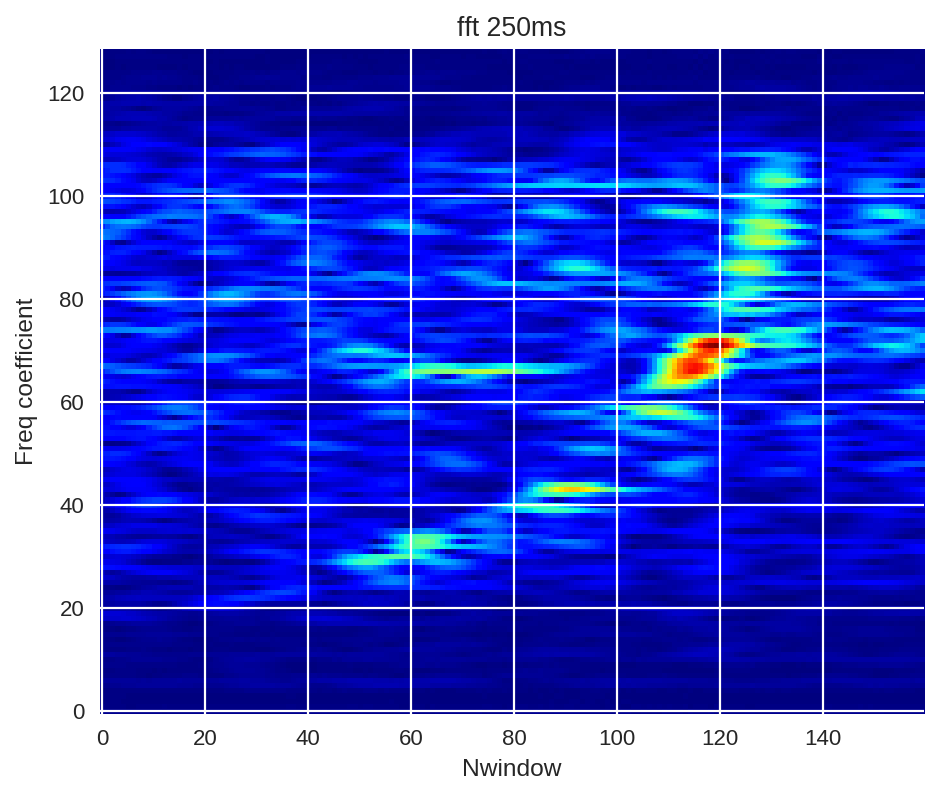

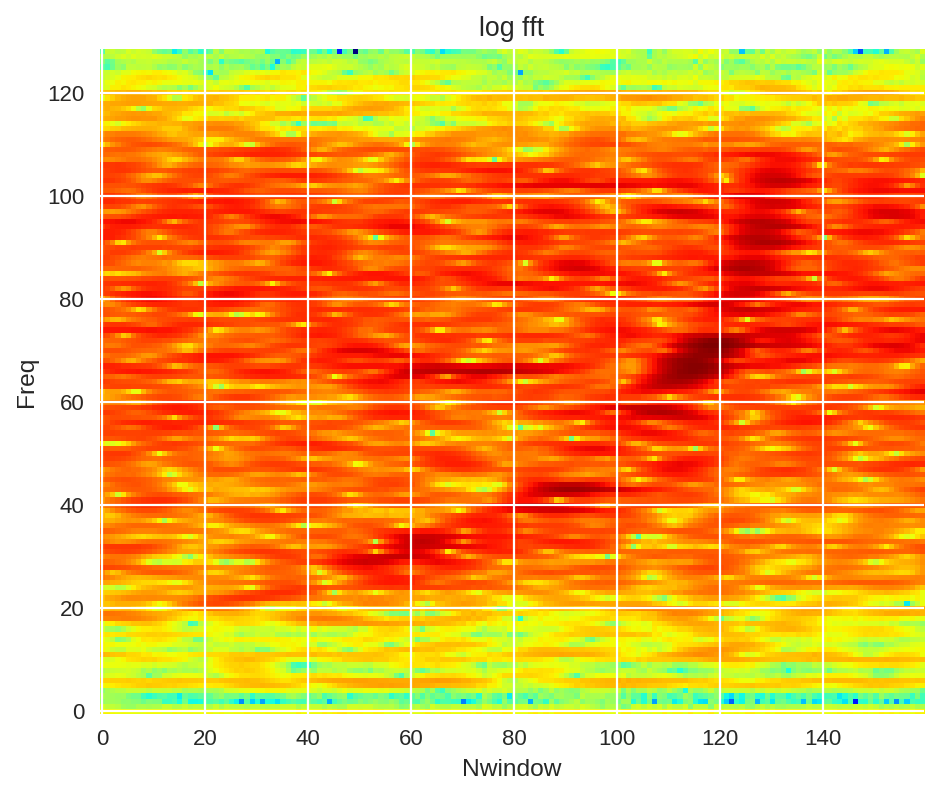

In [25]:
Nsound = 12
x = sounds[Nsound,:]
print('label:',labels[Nsound])


# fname = 'train7.aiff'
# x, fs = sf.read(fname)

decimate_factor = 2
fs = 2000 / decimate_factor


x = signal.decimate(x, decimate_factor)

NFFT = 256

N = int(fs * 0.25)
M = int(fs * 0.011)

x_win = windower(x, M, N)

print('x_win:', x_win.shape)

W = np.expand_dims(np.hamming(x_win.shape[1]), axis=0)
x_hamm = x_win * W


s = np.abs(np.fft.rfft(x_hamm, n=NFFT, axis=1))

print('s:', s[:,1:].shape)
s = s.astype(np.float32)
print(s.dtype)

faxis = np.linspace(0, fs/2, NFFT/2+1)


plt.figure(dpi=160)
plt.imshow(s.T, cmap='jet')
plt.gca().invert_yaxis()
plt.title('fft 250ms')
plt.xlabel('Nwindow')
plt.ylabel('Freq coefficient')
plt.savefig('fft_250ms.png')
files.download('fft_250ms.png')


plt.figure(dpi=160)
plt.imshow(np.log(s.T), cmap='jet')
plt.gca().invert_yaxis()
plt.title('log fft')
plt.xlabel('Nwindow')
plt.ylabel('Freq')


### Apply Filter bank

(160, 129)
(32, 129)


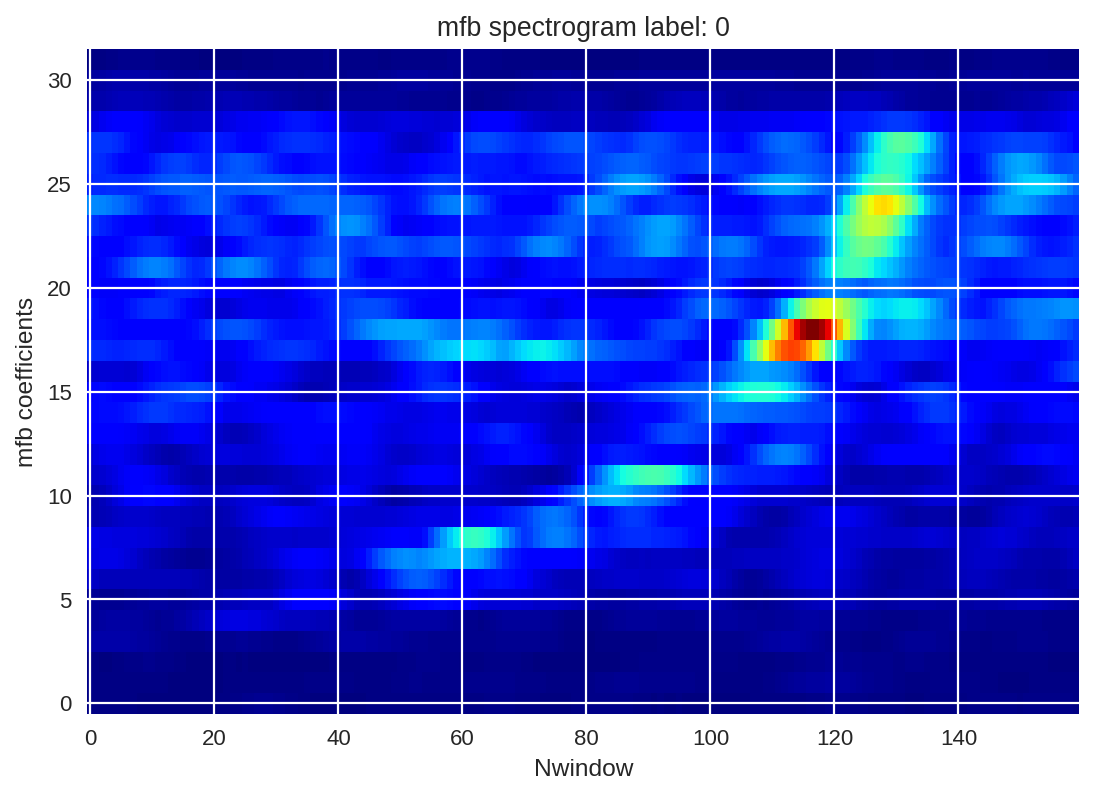

In [26]:
# apply MFB

mfb = gen_whalefb_mtx(NFFT=256, nfilt=32, sample_rate=fs)

print(s.shape)
print(mfb.shape)

s_mfb = np.matmul(s, mfb.T)

plt.figure(dpi=160)
plt.imshow(s_mfb.T, cmap='jet', aspect='auto')
plt.gca().invert_yaxis()
plt.title('mfb spectrogram label: 0')
plt.xlabel('Nwindow')
plt.ylabel('mfb coefficients')
plt.savefig('mfb_spectrogram.png')

# files.download('mfb_spectrogram.png')

### Compute gradient features with respect to time (delta features).

In [0]:
# NOTE: USE DELTA FEATURES AS INPUT CHANNELS

filter1 = np.array([-1.0000,   -0.7500,   -0.5000,   -0.2500,         0,    0.2500,    0.5000,   0.7500,    1.0000])
filter2 = np.array([ 1.0000,    0.2500,   -0.2857,   -0.6071,   -0.7143,   -0.6071,   -0.2857,   0.2500,    1.0000])

def get_mtx_deltas(X, filter1, filter2):
    Nwin = X.shape[0]
    W1 = get_delta_mtx(filter1, Nwin)
    W2 = get_delta_mtx(filter2, Nwin)
    delta1 = np.dot(W1, X)    
    delta2 = np.dot(W2, X)
    
    # add new dimension to get delta features as channels
    out = np.concatenate((np.expand_dims(X, axis=2), np.expand_dims(delta1, axis=2), np.expand_dims(delta2,axis=2)), axis=2)
    return out
    

def get_delta_mtx(the_filter, Nwin):
    # returns Nwin by Nwin matrix W1. W1 * base_features = delta1 
    Fsize = len(the_filter)
    T_pad = (Fsize-1)
    Nwin_pad = Nwin + T_pad
    pad_s = int(T_pad/2)
    pad_e = int(T_pad/2) #+ Nwin_pad%2
    #print('padding start, end:', pad_s, pad_e)
    # Generate Filter
    W1 = np.zeros((Nwin, Nwin_pad))
    for i in range(Nwin_pad - Fsize + 1):
        W1[i, i:i+Fsize] = the_filter
    W1 = W1[:,pad_s:]   
    W1 = W1[:,:-pad_e]
    return W1

(160, 31, 3)
(3, 160, 31)


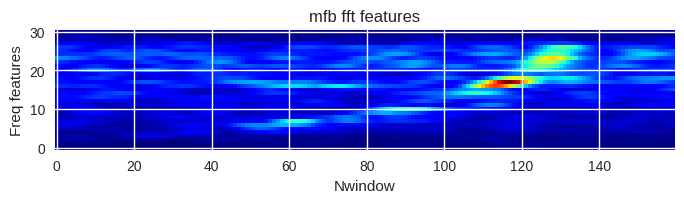

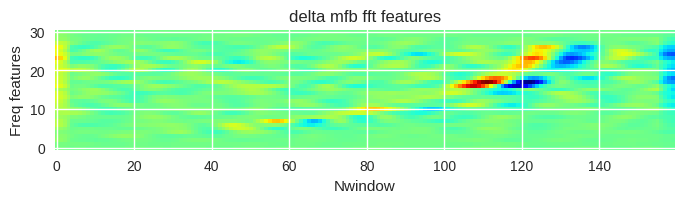

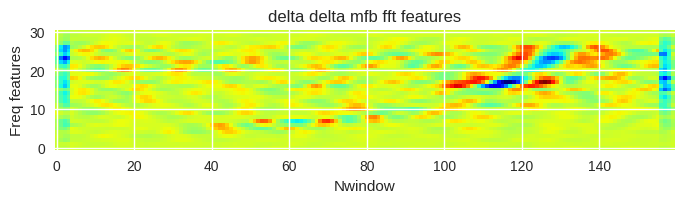

In [29]:
s_augment = get_mtx_deltas(s_mfb, filter1, filter2)
s_augment = s_augment[:,1:,:]
print(s_augment.shape)

plt.figure(dpi=100)
plt.imshow(s_augment[:,:,0].T, cmap='jet')
plt.gca().invert_yaxis()
plt.title('mfb fft features')
plt.xlabel('Nwindow')
plt.ylabel('Freq features')
plt.savefig('mfb_feat.png')

plt.figure(dpi=100)
plt.imshow(s_augment[:,:,1].T, cmap='jet')
plt.gca().invert_yaxis()
plt.title('delta mfb fft features')
plt.xlabel('Nwindow')
plt.ylabel('Freq features')
plt.savefig('mfb_delta_feat.png')

plt.figure(dpi=100)
plt.imshow(s_augment[:,:,2].T, cmap='jet')
plt.gca().invert_yaxis()
plt.title('delta delta mfb fft features')
plt.xlabel('Nwindow')
plt.ylabel('Freq features')
plt.savefig('mfb_deltadelta_feat.png')

s_augment = np.rollaxis(s_augment, 2, 0)
print(s_augment.shape)

In [0]:
files.download('mfb_feat.png')
files.download('mfb_delta_feat.png')
files.download('mfb_deltadelta_feat.png')

## Process full dataset

In [12]:
## function to prepare dataset -> out of memory

decimate_factor = 2
fs = 2000 / decimate_factor

NFFT = 256

wfb = gen_whalefb_mtx(NFFT, nfilt=32, sample_rate=fs)

N = int(fs * 0.25)
M = int(fs * 0.011)

W = np.expand_dims(np.hamming(N), axis=0)

ready_data = np.zeros((sounds.shape[0], 160, 32, 3))

for i in range(sounds.shape[0]):

    x = sounds[i]
    x = signal.decimate(x, decimate_factor)

    x_win = windower(x, M, N)
    x_hamm = x_win * W

    s = np.abs(np.fft.rfft(x_hamm, n=NFFT, axis=1))
#     s = s[:,1:] #eliminate DC
    s = np.matmul(s, wfb.T)
    
    s_augment = get_mtx_deltas(s, filter1, filter2)
#     s_augment = np.rollaxis(s_augment, 2, 0)
    
    ready_data[i] = s_augment
    
print(ready_data.shape)
print(ready_data.dtype)
ready_data = ready_data.astype(np.float32)
print(ready_data.dtype)

np.save(basePath + '/' + 'processed_data_250ms.npy', ready_data)

(30000, 160, 32, 3)
float64
float32


In [28]:
print(ready_data.shape)

(30000, 198, 32, 3)
